# introduction
In this assignment I want to show the potential ET in two different places in the United States. In each of the places the potential ET is calculated using:
1. Thornthwaite's equation
2. Penman's equation.

For this purpose we will use data taken from the meteorological stations located in **Santa Barbara** (California) and **Sitka** (Alaska) in 2015.
The climate in Santa Barbara is [very warm in summer](https://en.wikipedia.org/wiki/Santa_Barbara,_California#Climate) so my hypothesis is that the potential ET in it will be higher than in stika, which is characterized by a [very cold and wet climate](https://en.wikipedia.org/wiki/Sitka,_Alaska#Climate)

It will be interesting to compare the different equations as well because the Penman's equation takes into account other factors so we can find differences within each station and between the stations (for example the strong wind that exists in Stika or the moisture that exists in Santa Barbara)


##### Santa Barbara map
![santa_barbara.PNG](santa_barbara.PNG)

##### Sitka map
![lake.jpg](alaska.PNG)

### 1) importing and orgenizing the data
first let's import all the libraries we will need to use during the data analysis:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from functools import reduce
import seaborn as sns
sns.set(style="ticks", font_scale=1.5)
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import urllib.request

Now lets import the data for the 2 stations and give them names.(you can uncomment for seeing the table).
first we will do it to the data from Santa Barbara california:

In [2]:
data_file = "CRNS0101-05-2015-CA_Santa_Barbara_11_W.txt"
df_cal = pd.read_csv(data_file,                    #cal = california for Santa Barbara
                 header=None,                      # no headers needed, we'll do that later
                 delim_whitespace=True,            # blank spaces separate between columns
                 na_values=["-99.000", "-9999.0"]  # substitute these values for missing (NaN) values
                )
headers = pd.read_csv("HEADERS.txt",    # load headers file
                      header=1,                    # skip the first [0] line
                      delim_whitespace=True
                     )
df_cal.columns = headers.columns                       # rename df columns with headers columns
# LST = local standard time
df_cal["LST_TIME"] = [f"{x:04d}" for x in df_cal["LST_TIME"]]  # time needs padding of zeros, then convert to string
df_cal['LST_DATE'] = df_cal['LST_DATE'].astype(str)            # convert date into string
df_cal['datetime'] = df_cal['LST_DATE'] + ' ' + df_cal['LST_TIME'] # combine date+time into datetime
df_cal['datetime'] = pd.to_datetime(df_cal['datetime'])        # interpret datetime
df_cal = df_cal.set_index('datetime')                          # make datetime the index
# df_cal

According to the [station details](https://tidesandcurrents.noaa.gov/stationhome.html?id=9411340), its height above sea level is 2.63 (meters), so we will add another column of air pressure (Kpa) according to the formula:

$ P (Kpa) =101.3−0.01055*H(m) $

In [3]:
H = 2.63 #[m]
df_cal["AIR_PRESSURE"] =101.3 -(H*0.01055)
#df_cal["AIR_PRESSURE"]        #uncomment to see the value

An initial graph is made to make sure we do not have missing information:
(As you can see from the graph the data seems continuous and reliablein excluding the radiation data there is one day with exremely high radiation.I do not know if this is a mistake or an unusual event such as a particularly dry and hot day, a fire, etc. 
For now we will leave the data as it is and if we see anomalies in the results we will delete this specific day...

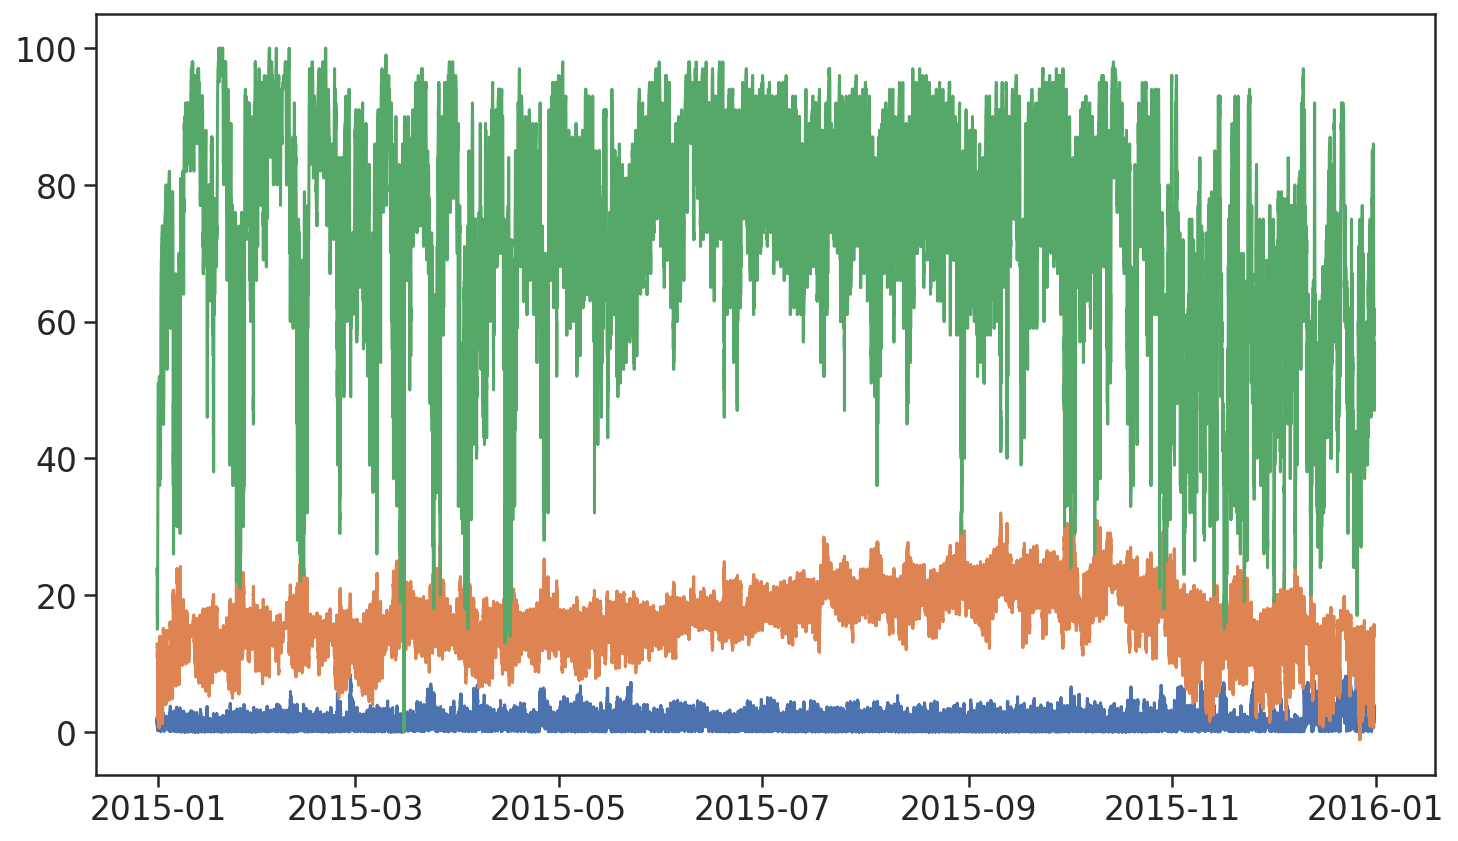

In [4]:
#plt.plot(df_cal["SOLAR_RADIATION"]) #uncomment to see the range of radiation. i'm hiding it because its scale diturb to see the rest of the data
plt.plot(df_cal["WIND_1_5"])
plt.plot(df_cal["AIR_TEMPERATURE"])
plt.plot(df_cal["RELATIVE_HUMIDITY"])

Now let's do the same process for the Sikta (Alaska) information file:

In [5]:
data_file = "CRNS0101-05-2015-AK_Sitka_1_NE.txt"
df_ak = pd.read_csv(data_file,                       #ak = short name of "Alaska" for the data of Lake Clark
                 header=None,                      # no headers needed, we'll do that later
                 delim_whitespace=True,            # blank spaces separate between columns
                 na_values=["-99.000", "-9999.0"]  # substitute these values for missing (NaN) values
                )
headers = pd.read_csv("HEADERS.txt",    # load headers file
                      header=1,                    # skip the first [0] line
                      delim_whitespace=True
                     )
df_ak.columns = headers.columns                       # rename df columns with headers columns
# LST = local standard time
df_ak["LST_TIME"] = [f"{x:04d}" for x in df_ak["LST_TIME"]]  # time needs padding of zeros, then convert to string
df_ak['LST_DATE'] = df_ak['LST_DATE'].astype(str)            # convert date into string
df_ak['datetime'] = df_ak['LST_DATE'] + ' ' + df_ak['LST_TIME'] # combine date+time into datetime
df_ak['datetime'] = pd.to_datetime(df_ak['datetime'])        # interpret datetime
df_ak = df_ak.set_index('datetime')                          # make datetime the index
#df_ak

According to the [station details](https://tidesandcurrents.noaa.gov/stationhome.html?id=9451600), its height above sea level is 5.1419 (meters), so we will add another column of air pressure (Kpa) according to the same formula:

In [6]:
H = 5.1419 #[m]
df_ak["AIR_PRESSURE"] =101.3 -(H*0.01055)
#df_ak["AIR_PRESSURE"]        #uncomment to see the value

Now let's do some initial graphs.
It can be seen that for radiation there is a value equal to -9999. We will delete its entire line so that it does not interfere with the analysis

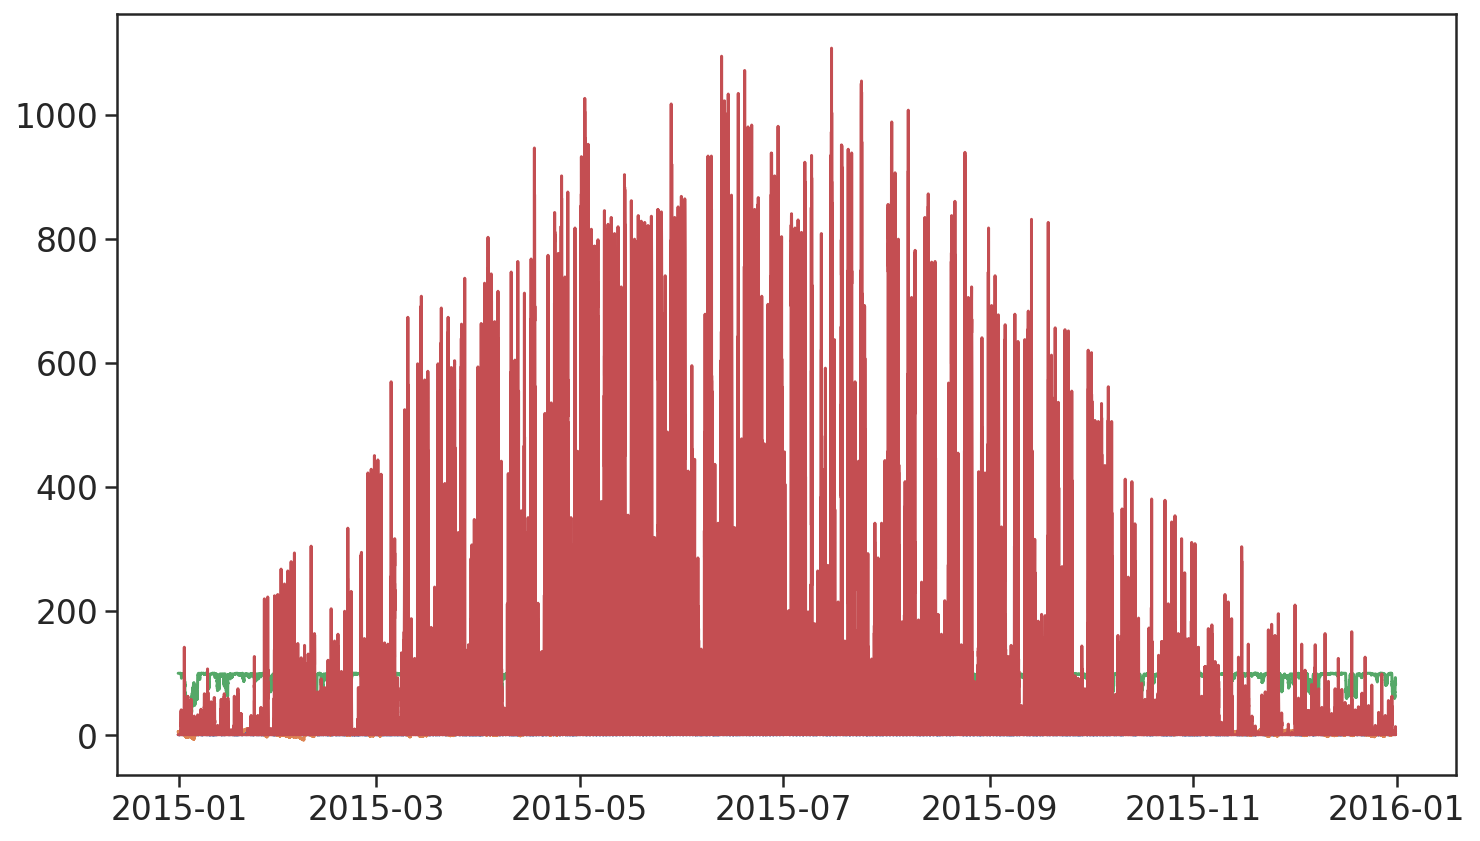

In [7]:
#plt.plot(df_ak["SOLAR_RADIATION"]) #uncomment to see the range of radiation. i'm hiding it because its scale diturb to see the rest of the data
plt.plot(df_ak["WIND_1_5"])
plt.plot(df_ak["AIR_TEMPERATURE"])
plt.plot(df_ak["RELATIVE_HUMIDITY"])
df_ak = df_ak[df_ak.SOLAR_RADIATION != -99999] #deleting the row based on column value
plt.plot(df_ak["SOLAR_RADIATION"]) #now its good. you can uncomment line 1 to see the different

### 2) Thornthwaite's equation
Is an equation designed to calculate the potential ET. Its great advantage is that for its use it is sufficient to know only the temperature. Its main disadvantage is the level of accuracy because it is known that there are other factors that affect ET (for example wind, VPD, air resistance, etc.)
It is important to note that this equation is empirical and therefore does not explain the physics behind things. In addition it is not suitable for every area

$$
\begin{equation}
E = 16\left[ \frac{10\,T^\text{monthly mean}}{I} \right]^a,
\end{equation}
$$
where
$$
\begin{equation}
I = \sum_{i=1}^{12} \left[ \frac{T_i^\text{monthly mean}}{5} \right]^{1.514},
\end{equation}
$$
and
$$
\begin{align}
a &= 6.75\times 10^{-7}I^3 \\
   &- 7.71\times 10^{-5}I^2 \nonumber\\
   &+ 1.792\times 10^{-2}I \nonumber\\
   &+ 0.49239 \nonumber
\end{align}
$$

 - $E$ is the monthly potential ET (mm)
 - $T_\text{monthly mean}$ is the mean monthly temperature in °C
 - $I$ is a heat index
 - $a$ is a location-dependent coefficient



first, lets make a new dataframe, df_th, that stores monthly temperatures means using `resample` function.

(We'll do the whole calculation for California and then the same thing for Alaska)



We do not want a negative temp to create a data error for us. Therefore, suppose that for temperatures below zero there is no evaporation at all. Any temperature lower than zero will get the value 0 so that there will be no error in the calculation:

In [8]:
df_cal["AIR_TEMPERATURE"][df_cal["AIR_TEMPERATURE"]<0] = 0
df_cal["AIR_TEMPERATURE"].min()

<ipython-input-8-af38f2a6f866>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cal["AIR_TEMPERATURE"][df_cal["AIR_TEMPERATURE"]<0] = 0


0.0

In [9]:
# monthly data Sabta Barbara California
df_th_cal = (df_cal["AIR_TEMPERATURE"].resample('MS')  # MS assigns mean to first day in the month
                .mean()
                .to_frame()
        )
# we now add 14 days to the index, so that all monthly data is in the middle of the month
# not really necessary, makes plot look better
df_th_cal.index = df_th_cal.index + pd.DateOffset(days=14)
#plt.plot(df_th_cal) #uncomment to see the graph
#df_th_cal           #uncomment to see the new DataFrame

Now we can Calculate $I$, then $a$, and finally $E_p$. we will add $E_p$ as a new column in df_th_cal.

In [10]:
# Preparing "I" for the Thornthwaite equation
I = np.sum( (df_th_cal["AIR_TEMPERATURE"]/5)**(1.514) )

# Preparing "a" for the Thornthwaite equation
a = (+6.75e-7 * I**3
     -7.71e-5 * I**2
     +1.792e-2 * I
     + 0.49239)

# The final Thornthwaite model for monthly potential ET (mm)
df_th_cal['Ep'] = 16*((10*df_th_cal["AIR_TEMPERATURE"]/I)**a)
df_th_cal

,AIR_TEMPERATURE,Ep
datetime,,
2014-12-15,6.994681,14.558539
2015-01-15,12.674258,39.287221
2015-02-15,13.966456,46.202675
2015-03-15,15.378155,54.263233
2015-04-15,14.926158,51.625954
2015-05-15,14.563771,49.549757
2015-06-15,16.841123,63.156431
2015-07-15,19.089718,77.860347
2015-08-15,20.547726,88.043753


Okay, so we calculated ET in Santa Barbara :)
Now what we do is  to do the same for Sitka and display it all in graphs:

In [11]:
#chnging all the negative values of temperture into 0:
df_ak["AIR_TEMPERATURE"][df_ak["AIR_TEMPERATURE"]<0] = 0
# monthly data Sitka Alaska
df_th_ak = (df_ak["AIR_TEMPERATURE"].resample('MS')  # MS assigns mean to first day in the month
                .mean()
                .to_frame()
        )
# we now add 14 days to the index, so that all monthly data is in the middle of the month
# not really necessary, makes plot look better
df_th_ak.index = df_th_ak.index + pd.DateOffset(days=14)
#plt.plot(df_th_ak) #uncomment to see the graph
#df_th_ak           #uncomment to see the new DataFrame

In [12]:
# Preparing "I" for the Thornthwaite equation
I = np.sum( (df_th_ak["AIR_TEMPERATURE"]/5)**(1.514) )

# Preparing "a" for the Thornthwaite equation
a = (+6.75e-7 * I**3
     -7.71e-5 * I**2
     +1.792e-2 * I
     + 0.49239)

# The final Thornthwaite model for monthly potential ET (mm)
df_th_ak['Ep'] = 16*((10*df_th_ak["AIR_TEMPERATURE"]/I)**a)
df_th_ak

,AIR_TEMPERATURE,Ep
datetime,,
2014-12-15,3.841121,23.871941
2015-01-15,4.229576,26.024854
2015-02-15,3.411136,21.462228
2015-03-15,4.218683,25.964769
2015-04-15,4.851771,29.431442
2015-05-15,9.676736,54.645111
2015-06-15,11.965625,66.099326
2015-07-15,13.390681,73.113457
2015-08-15,13.287388,72.607751


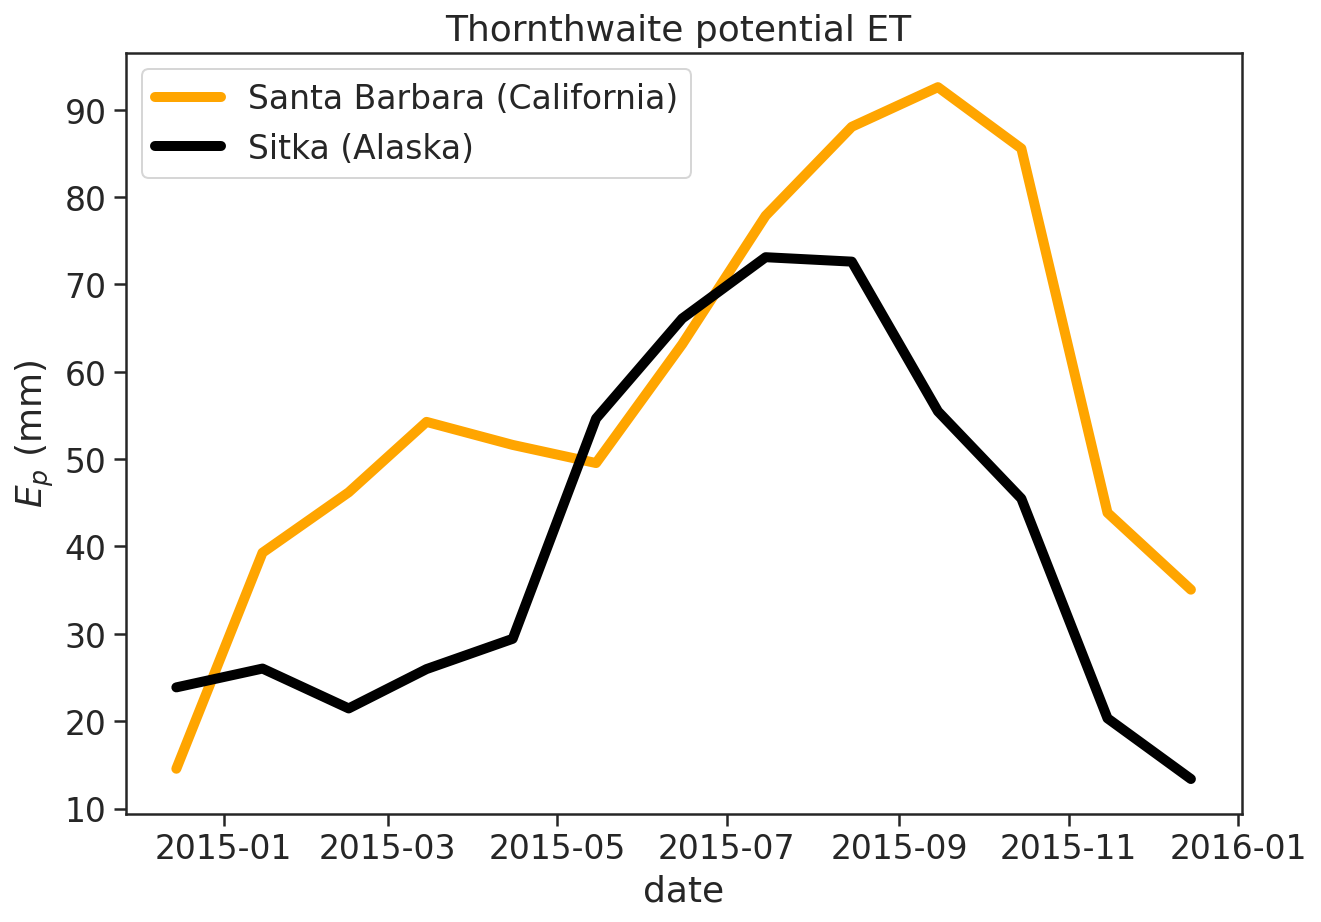

In [13]:
#graph:
fig, ax = plt.subplots(1, figsize=(10,7))
ax.plot(df_th_cal['Ep'], color="orange",  linewidth=5, label="Santa Barbara (California)")
ax.plot(df_th_ak['Ep'], color="black",linewidth=5, label="Sitka (Alaska)")
ax.set(xlabel="date",
       ylabel=r"$E_p$ (mm)",
       title="Thornthwaite potential ET ");
ax.legend(loc='upper left')

<!--
```python
#Some additional calculations are made in order to include them in the analysis:
print("ak sum = ",df_th_ak['Ep'].sum()  )
print("cal sum = ",df_th_cal['Ep'].sum()  )
print("ak min = ",df_th_ak['Ep'].min()  )
print("cal min = ",df_th_cal['Ep'].min()  )
print("ak max = ",df_th_ak['Ep'].max()  )
print("cal max = ",df_th_cal['Ep'].max()  )
print("ak average = ",df_th_ak['Ep'].mean()  )
print("ak average = ",df_th_cal['Ep'].mean()  )

```
-->
We will summarize the findings in the table


| Station | Sitka (Alaska) | Santa Barbara (California) |
| --- | --- | --- |
| Total annual ET |527.88(mm))| 741.6 (mm) |
| Average ET | 40.6 (mm)|  57.04 (mm) |
| ET minimum (monthly average) | 13.88 (mm) | 14.55 (mm) |
| ET maximum (monthly average)  | 73.44 (mm) | 92.58 (mm) |

As you can see the ET in Santa Barbara is higher almost any time of the year. The minimum and maximum value in Santa Barbara (14.15 and 92.58 respectively) is also higher than the minimum and maximum value in Sitka (11.88 and 73.44 respectively). In addition it can be seen that the months in which the ET values are maximum are different everywhere (2 month apart).
Also the total ET in Santa Barbara is higher with 214 mm more in Santa Barbara.

### 3) Penman's equation

This equation is more accurate because it takes into account many other variables that affect ET. Its advantage is also its disadvantage because in order to calculate ET using this equation we will need more data (it does not always exist).
We will now present the equation and all the parts that make it up. We will then perform the calculation for each of the stations, compare them and also compare the results we got with the help of Thornthwaite's equation

$$
\begin{equation}
E = \frac{1}{\lambda}\left[ \frac{\Delta}{\Delta+\gamma}Q_{ne}+ \frac{\gamma}{\Delta+\gamma}E_A \right],
\end{equation}
$$

where $Q_n$ is the available energy flux density

$$
\begin{equation}
Q_n = R_n - G,
\end{equation}
$$

and $E_A$ is the drying power of the air

$$
\begin{equation}
E_A = 6.43\cdot f(u)\cdot\text{VPD}.
\end{equation}
$$


$$
  \begin{equation}
    \gamma = \frac{c_p\, P}{\lambda\cdot MW_\text{ratio}}
  \end{equation}
$$
  
  $$
  \begin{equation}
    P = 101.3-0.01055 H
  \end{equation}
  $$

  $$
  \begin{equation}
    \lambda = 2.501 - 2.361\times 10^{-3}\,T
  \end{equation}
  $$

* $MW_\text{ratio}=0.622$: ratio molecular weight of water vapor/dry air
* $P$: atmospheric pressure (kPa). Can be either measured or inferred from station height above sea level (m).
* $\lambda$: latent heat of water vaporization (MJ kg$^{-1}$)








$$R_n = (1-\alpha)R_s\!\! \downarrow -R_b \!\! \uparrow,$$

where $\alpha$ (dimensionless) is the albedo.
The net outgoing thermal radiation $R_b$ is given by

$$R_b = \left( a\frac{R_s}{R_{so}+b} \right)R_{bo},$$

where $R_{so}$ is the solar radiation on a cloudless day, and it depends on latitude and day of the year.
$R_{bo}$ is given by

$$R_{bo} = \epsilon\, \sigma\, T^4_{Kelvin},$$

where $\sigma=4.903\times 10^{-9}$ MJ m$^{-2}$ d$^{-1}$ K$^{-4}$, and $\epsilon$ is net net emissivity:

$$\epsilon=-0.02+0.261 \exp\left(-7.77\times10^{-4}T_{Celcius}\right).$$

The parameters $a$ and $b$ are determined for the climate of the area:
* $a=1.0$, $b=0.0$ for humid areas,
* $a=1.2$, $b=-0.2$ for arid areas,
* $a=1.1$, $b=-0.1$ for semihumid areas.








$$
  \begin{equation}
    G = 4.2\frac{T_{i+1}-T_{i-1}}{\Delta t},
  \end{equation}
$$









$$\text{VPD} = e_s - e_d.$$

For temperatures ranging from 0 to 50 °C, the saturation vapor pressure can be calculated with

$$
  \begin{equation}
    e_s = \exp \left[ \frac{16.78\, T -116.9}{T+237.3} \right],
  \end{equation}
$$

and the actual vapor pressure is given by

$$
  \begin{equation}
    e_d = e_s \frac{RH}{100},
  \end{equation}
$$











$$
  \begin{equation}
    \Delta = \frac{\text{d} e_s}{\text{d}T} = e_s(T)\cdot \frac{4098.79}{(T+237.3)^2}.
  \end{equation}
$$









$$
  \begin{equation}
    f(u) = 0.26(1.0 + 0.54\, u_2)
  \end{equation}
$$








The various components of the equations above are:

  $$
  \begin{equation}
    \Delta = 0.200 \cdot (0.00738\,T + 0.8072)^7 - 0.000116
  \end{equation}
  $$

  $$
  \begin{equation}
    \gamma = \frac{c_p\, P}{0.622 \lambda}
  \end{equation}
  $$
  
  $$
  \begin{equation}
    P = 101.3-0.01055 H
  \end{equation}
  $$

  $$
  \begin{equation}
    \lambda = 2.501 - 2.361\times 10^{-3}\,T
  \end{equation}
  $$

  $$
  \begin{equation}
    f_e(u) = 1.0 + 0.53\, u_2
  \end{equation}
  $$
  
  $$
  \begin{equation}
    G = 4.2\frac{T_{i+1}-T_{i-1}}{\Delta t}
  \end{equation}
  $$
  
  $$
  \begin{equation}
    e_s = \exp \left[ \frac{16.78\, T -116.9}{T+237.3} \right]
  \end{equation}
  $$
  
  $$
  \begin{equation}
    e_d = e_s \frac{RH}{100}
  \end{equation}
  $$
where $\Delta t$ is the time *in days* between midpoints of time periods $i+1$ and $i−1$, and $T$ is the air temperature (°C).


 - $\Delta$: slope of the saturation water vapor pressure curve (kPa °C$^{-1}$)
 - $\gamma$: psychrometric constant (kPA °C$^{-1}$)
 - $c_p=0.001013$: specific heat of water at constant pressure (MJ kg$^{-1}$ °C$^{-1}$)
 - $P$: atmospheric pressure (kPa)
 - $H$: elevation above sea level (m)
 - $\lambda$: latent heat of vaporization (MJ kg$^{-1}$)
 - $R_n$: net radiation (MJ m$^{-2} d^{-1}$)
 - $G$: heat flux density to the ground (MJ m$^{-2} d^{-1}$)
 - $u_{2}$: wind speed measured 2 m above ground (m s$^{-1}$)
 - $e_{s} - e_{d}$: vapor pressure deficit (kPa) 
 - $e_{s}$: saturation vapor pressure (kPa) 
 - $e_{d}$: actual vapor pressure (kPa) 

We will create new DataFrame called "df_pen" and we will create columns for the various variables. (Here too first for Santa Barbara California and then for Sitka Alaska)

In [14]:
#resampling sub-hourly data over same day and taking mean, to obtain daily averages:

df_pen_cal = (df_cal['AIR_TEMPERATURE'].resample('D')     #cal =california for Santa Barbara just to not confusing the files
                 .mean()
                 .to_frame()
         )
df_pen_cal['u'] = (df_cal["WIND_1_5"].resample('D')
                               .mean()
              )
df_pen_cal['P'] = (df_cal["AIR_PRESSURE"].resample('D')
                             .mean()
              )
df_pen_cal['RH'] = (df_cal['RELATIVE_HUMIDITY'].resample('D')
                                           .mean()
               )
df_pen_cal['daily_radiation_MJ/m^2*day'] = (df_cal['SOLAR_RADIATION'].resample('D')
                                           .mean()
               )/(1000000/86000)                          #convert from w/(m^2*day) into MJ/(m^2*day)
#df_pen_cal                                               #uncomment to see the DataFrame

With average $T$ for every day of the year, we can now calculate daily latent heat of vaporization $\lambda$, the slope of the saturation-vapor pressure-temperature curve $\Delta$, and the heat flux density to the ground $G$.We will add each of these to dataframe `df_pen`.  

Lets also calculate the wind function using the data for wind speed, and add this to `df_pen`:

In [15]:
def lambda_latent_heat(T):
    """daily latent heat of vaporization (MJ/kg)"""
    return 2.501 - 2.361e-3*T

def Delta(T):
    """slope of saturation-vapor curve (kPa/°C)"""
    return 0.2000*(0.00738*T + 0.8072)**7 - 0.000116

def G(T):
    """heat flux density to the ground, G (MJ/m2/d)"""
    return 4.2*np.gradient(T.values)      #It's basically a derivative:)

cp = 0.001013  # (MJ kg−1 °C−1) 
df_pen_cal['lambda'] = lambda_latent_heat(df_pen_cal['AIR_TEMPERATURE'])
df_pen_cal['Delta'] = Delta(df_pen_cal['AIR_TEMPERATURE'])
df_pen_cal['G'] = G(df_pen_cal['AIR_TEMPERATURE'])
df_pen_cal['gamma'] = (cp*df_pen_cal["P"])/(0.622*df_pen_cal['lambda'])
df_pen_cal['f_wind'] = 1.0 + 0.53 * df_pen_cal['u']
#df_pen_cal                               #uncomment to see the DataFrame

It's time to calculate net radiation $R_n$. The [monthly mean solar radiation](https://yairmau.com/jupyter/2020/02/01/evapotranspiration-lecture.html) $R_{so}$ for latitude 35 degrees (which is the latitude of Santa Barbara) is
`[14.95,19.55, 24.58,29.31, 32.11, 33.49, 32.66, 29.18, 23.74, 18.42, 13.52, 10.76]` (MJ m$^{-2}$ d$^{-1}$).

We will add a new column `Rso_monthly` to `df_pen`, where each day has the appropriate $R_{so}$ given by the data above. 
And also we will add a new columns `Rs` with the global radiation.

In [16]:
# Rso: mean solar radiation from a cloudless sky (based on latitude)
# MJ/m2/d
Rso_monthly_cal = np.array([14.95,19.55, 24.58,29.31, 32.11, 33.49, 32.66, 29.18, 23.74, 18.42, 13.52, 10.76])

# creating empty columns
df_pen_cal["Rso_monthly"] = ""

# every day in the month will have the same values for Rso
for i in range(12):
    df_pen_cal.loc[df_pen_cal.index.month==(i+1), "Rso_monthly"] = Rso_monthly_cal[i]
#df_pen_cal                                       #uncomment to see the DataFrame

from: Ward & Trimble, "Environmental Hydrology", 2nd Edition, page 99.

* lets Calculate 
  $$R_{bo} = \epsilon\, \sigma\, T^4_{Kelvin},$$
  where
  $$\epsilon=-0.02+0.261 \exp\left(-7.77\times10^{-4}T_{Celcius}\right),$$  
  $$\sigma=4.903\times 10^{-9} \text{  MJ m$^{-2}$ d$^{-1}$ K$^{-4}$},$$
  and
  $$T_{Kelvin}=T_{Celcius}+273.15$$
* in addition we will calculate 
  $$R_b = \left( a\frac{R_s}{R_{so}+b} \right)R_{bo},$$
  
  where  for humid areas,such as Santa Barbara $a=1.0$ and $b=0$,  

* Finally, we will calculate 
  $$R_n = (1-\alpha)R_s\!\! \downarrow -R_b \!\! \uparrow,$$
  where  
  - $\alpha= 0.23$ for most green crops with a full cover
  - $\alpha= 0.04$ for fresh asphalt
  - $\alpha= 0.12$ for worn-out asphalt
  - $\alpha= 0.55$ for fresh concrete
    Santa Barbara is a relatively densely populated area but it also has a lot of gardens so we will do kind of avarege:
    $\alpha = (1/3)*0.23 + (1/3)*0.55 +(1/3)* 0.12 =0.3 $ assuming all the asphalt is worn-out
We will add a new column `Rn` to `df_pen` dataframe:

In [17]:
df_pen_cal['T(k)'] = df_pen_cal['AIR_TEMPERATURE']+273.15
sigma = 4.903e-9
df_pen_cal["emissivity"] = -0.02 +0.261*np.exp(-7.77e-4*(df_pen_cal['AIR_TEMPERATURE']**2))
df_pen_cal["Rbo"] = df_pen_cal["emissivity"]*sigma*(df_pen_cal['T(k)']**4)
a = 1.0
b = 0
df_pen_cal["Rb"] = (a*df_pen_cal['daily_radiation_MJ/m^2*day']/df_pen_cal['Rso_monthly'] + b)*df_pen_cal['Rbo']
albedo = 0.3
df_pen_cal['Rn'] = (1-albedo)*df_pen_cal['daily_radiation_MJ/m^2*day']-df_pen_cal['Rb']
#df_pen_cal                                       #uncomment to see the DataFrame

Now lets calculate the vapor pressure deficit, VPD, add a new column to `df_pen`.

$$e_d = e_s\cdot \frac{RH}{100}$$

$$e_s = \exp\left(\frac{16.78\,T-116.9}{T+237.3}\right)$$

In [18]:
# vapor pressure deficit = VPD
def vp_sat(T):
    return np.exp((16.78*T - 116.9)/(T + 237.3)) 
df_pen_cal['es'] = vp_sat(df_pen_cal['AIR_TEMPERATURE'])
df_pen_cal['ed'] = df_pen_cal['es'] * df_pen_cal['RH'] / 100
df_pen_cal['VPD'] = df_pen_cal['es'] - df_pen_cal['ed']
#df_pen_cal                                       #uncomment to see the DataFrame

Now that all variables have been defined, daily E_penman can be calculated. 

$$
\begin{equation}
E_{tp} = \frac{\Delta}{\Delta+\gamma}Q_{ne}+ \frac{\gamma}{\Delta+\gamma}E_A
\end{equation}
$$

$Q_n$ is the available energy flux density:

$$
\begin{equation}
Q_n = R_n - G,
\end{equation}
$$

and $E_A$ is the drying power of the air:

$$
\begin{equation}
E_A = f_e(u)\cdot\text{VPD}
\end{equation}
$$

Lets add a new column `E_penman` to `df_pen`:

In [19]:
df_pen_cal['Qn'] = df_pen_cal['Rn'] - df_pen_cal['G']
df_pen_cal['Ea'] = 6.43*(1+0.53*df_pen_cal['u'])*df_pen_cal['VPD']
df_pen_cal['Etp'] = df_pen_cal['Qn']*(df_pen_cal['Delta']/(df_pen_cal['Delta']+df_pen_cal['gamma'])) + df_pen_cal['Ea']*(df_pen_cal['gamma']/(df_pen_cal['Delta']+df_pen_cal['gamma']))
df_pen_cal['E_penman'] = df_pen_cal['Etp']*(1/df_pen_cal['lambda'])
df_pen_cal                                       #uncomment to see the full DataFrame

,AIR_TEMPERATURE,u,P,RH,daily_radiation_MJ/m^2*day,lambda,Delta,G,gamma,f_wind,...,Rbo,Rb,Rn,es,ed,VPD,Qn,Ea,Etp,E_penman
datetime,,,,,,,,,,,,,,,,,,,,,
2014-12-31,6.994681,1.218632,101.272253,29.263158,0.554021,2.484486,0.068804,0.608590,0.066385,1.645875,...,6.983931,0.359595,0.028219,1.001929,0.293196,0.708733,-0.580371,7.500501,3.387771,1.36357
2015-01-01,7.139583,1.330104,101.272253,49.194444,12.202146,2.484143,0.069407,2.156379,0.066395,1.704955,...,6.986301,5.702199,2.839303,1.011944,0.497820,0.514124,0.682925,5.636266,3.104651,1.249787
2015-01-02,8.021528,1.287118,101.272253,64.239583,12.146903,2.482061,0.073176,4.321771,0.066450,1.682173,...,6.995192,5.683607,2.819225,1.074822,0.690461,0.384361,-1.502546,4.157390,1.191109,0.479887
2015-01-03,9.197569,1.301528,101.272253,70.322917,12.095542,2.479285,0.078472,4.478665,0.066525,1.689810,...,6.992190,5.657146,2.809734,1.164007,0.818564,0.345443,-1.668931,3.753407,0.818842,0.330274
2015-01-04,10.154225,1.527917,101.272253,74.149306,11.398583,2.477026,0.083019,6.242692,0.066585,1.809796,...,6.977195,5.319742,2.659266,1.241292,0.920409,0.320883,-3.583425,3.734107,-0.326574,-0.131841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,7.683333,1.600278,101.272253,57.826389,11.945639,2.482860,0.071711,-0.001458,0.066429,1.848147,...,6.992909,7.763454,0.598493,1.050315,0.607359,0.442956,0.599952,5.263905,2.842768,1.144957
2015-12-28,9.914236,2.301528,101.272253,52.770833,11.026813,2.477592,0.081858,2.372708,0.066570,2.219810,...,6.982014,7.155145,0.563624,1.221492,0.644591,0.576900,-1.809085,8.234317,2.695388,1.087906
2015-12-29,8.813194,1.203368,101.272253,53.114583,12.242458,2.480192,0.076706,-4.052708,0.066500,1.637785,...,6.995043,7.958785,0.610936,1.134168,0.602408,0.531759,4.663644,5.599934,5.098426,2.055658


That's it :) Before we present the data we created in the graph we will first create another dataframe for Sitka Alaska. The code is exactly the same so I will not elaborate on its explanation and introductions. If necessary, you can look at the previous explanations and thus understand the whole move:

In [20]:
#resampling sub-hourly data over same day and taking mean, to obtain daily averages:

df_pen_ak = (df_ak['AIR_TEMPERATURE'].resample('D')     #ak =Alaska for Sikta to not confusing between the files
                 .mean()
                 .to_frame()
         )
df_pen_ak['u'] = (df_ak["WIND_1_5"].resample('D')
                               .mean()
              )
df_pen_ak['P'] = (df_ak["AIR_PRESSURE"].resample('D')
                             .mean()
              )
df_pen_ak['RH'] = (df_ak['RELATIVE_HUMIDITY'].resample('D')
                                           .mean()
               )
df_pen_ak['daily_radiation_MJ/m^2*day'] = (df_ak['SOLAR_RADIATION'].resample('D')
                                           .mean()
               )/(1000000/86000)                          #convert from w/(m^2*day) into MJ/(m^2*day)
#df_pen_ak

cp = 0.001013  # (MJ kg−1 °C−1) 
df_pen_ak['lambda'] = lambda_latent_heat(df_pen_ak['AIR_TEMPERATURE'])
df_pen_ak['Delta'] = Delta(df_pen_ak['AIR_TEMPERATURE'])
df_pen_ak['G'] = G(df_pen_ak['AIR_TEMPERATURE'])
df_pen_ak['gamma'] = (cp*df_pen_ak["P"])/(0.622*df_pen_ak['lambda'])
df_pen_ak['f_wind'] = 1.0 + 0.53 * df_pen_ak['u']
#df_pen_ak                                                 #uncomment to see the dataframe

The [monthly mean solar radiation](https://yairmau.com/jupyter/2020/02/01/evapotranspiration-lecture.html) $R_{so}$ for latitude 55 degrees (which is the latitude of Sikta) is
`[4.31, 8.67, 16.33, 25.16, 29.85, 32.66, 30.56, 25, 18, 10.89, 5.57, 3.22]` (MJ m$^{-2}$ d$^{-1}$).

In [21]:
# Rso: mean solar radiation from a cloudless sky (based on latitude)
# MJ/m2/d
Rso_monthly_ak = np.array([4.31, 8.67, 16.33, 25.16, 29.85, 32.66, 30.56, 25, 18, 10.89, 5.57, 3.22])

# creating empty columns
df_pen_ak["Rso_monthly"] = ""

# every day in the month will have the same values for Rso
for i in range(12):
    df_pen_ak.loc[df_pen_ak.index.month==(i+1), "Rso_monthly"] = Rso_monthly_ak[i]
#df_pen_ak                                       #uncomment to see the DataFrame

Now we have to change some parameters in order to adapt them to the existing conditions in Sitka:

  $$R_b = \left( a\frac{R_s}{R_{so}+b} \right)R_{bo},$$
  where    
  - for arid areas, $a=1.2$ and $b=-0.2$, such is [the humadity in Skita](https://weatherspark.com/y/285/Average-Weather-in-Sitka-Alaska-United-States-Year-Round#Sections-Humidity)

Sitka has [almost no snow](https://wrcc.dri.edu/cgi-bin/cliMAIN.pl?ak8503) and has mostly plant cover, so we will consider its albedo:
- $\alpha= 0.23$ for most green crops with a full cover

In [22]:
df_pen_ak['T(k)'] = df_pen_ak['AIR_TEMPERATURE']+273.15
sigma = 4.903e-9
df_pen_ak["emissivity"] = -0.02 +0.261*np.exp(-7.77e-4*(df_pen_ak['AIR_TEMPERATURE']**2))
df_pen_ak["Rbo"] = df_pen_ak["emissivity"]*sigma*(df_pen_ak['T(k)']**4)
a = 1.2
b = -0.2
df_pen_ak["Rb"] = (a*df_pen_ak['daily_radiation_MJ/m^2*day']/df_pen_ak['Rso_monthly'] + b)*df_pen_ak['Rbo']
albedo = 0.23
df_pen_ak['Rn'] = (1-albedo)*df_pen_ak['daily_radiation_MJ/m^2*day']-df_pen_ak['Rb']

# vapor pressure deficit = VPD
df_pen_ak['es'] = vp_sat(df_pen_ak['AIR_TEMPERATURE'])
df_pen_ak['ed'] = df_pen_ak['es'] * df_pen_ak['RH'] / 100
df_pen_ak['VPD'] = df_pen_ak['es'] - df_pen_ak['ed']
#penman:
df_pen_ak['Qn'] = df_pen_ak['Rn'] - df_pen_ak['G']
df_pen_ak['Ea'] = 6.43*(1+0.53*df_pen_ak['u'])*df_pen_ak['VPD']
df_pen_ak['Etp'] = df_pen_ak['Qn']*(df_pen_ak['Delta']/(df_pen_ak['Delta']+df_pen_ak['gamma'])) + df_pen_ak['Ea']*(df_pen_ak['gamma']/(df_pen_ak['Delta']+df_pen_ak['gamma']))
df_pen_ak['E_penman'] = df_pen_ak['Etp']*(1/df_pen_ak['lambda'])
df_pen_ak                                               #uncomment to see the full DataFrame of Sitka


,AIR_TEMPERATURE,u,P,RH,daily_radiation_MJ/m^2*day,lambda,Delta,G,gamma,f_wind,...,Rbo,Rb,Rn,es,ed,VPD,Qn,Ea,Etp,E_penman
datetime,,,,,,,,,,,,,,,,,,,,,
2014-12-31,3.841121,0.001308,101.245753,99.000000,0.000000,2.491931,0.056747,6.434998,0.066170,1.000693,...,6.869859,-1.373972,1.373972,0.804535,0.796490,0.008045,-5.061026,0.051767,-2.308651,-0.92645
2015-01-01,5.373264,0.623125,101.245753,97.524306,0.147215,2.488314,0.062357,-6.060418,0.066266,1.330256,...,6.940067,-1.103554,1.21691,0.895677,0.873503,0.022174,7.277327,0.189668,3.625796,1.45713
2015-01-02,0.955208,0.299097,101.245753,83.267361,0.368785,2.498745,0.047344,-11.283854,0.065989,1.158522,...,6.665222,-0.648674,0.932638,0.654832,0.545261,0.109571,12.216492,0.816224,5.578613,2.232566
2015-01-03,0.000000,0.657361,101.245753,43.086806,0.687403,2.501000,0.044542,-2.005938,0.065930,1.348401,...,6.577847,-0.056647,0.585947,0.611020,0.263269,0.347751,2.591884,3.015079,2.844448,1.137324
2015-01-04,0.000000,0.455278,101.245753,42.395833,0.133181,2.501000,0.044542,1.108333,0.065930,1.241297,...,6.577847,-1.07166,1.174209,0.611020,0.259047,0.351973,0.065876,2.809287,1.703152,0.680988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,0.078125,0.076250,101.245753,98.743056,0.355646,2.500816,0.044766,2.638854,0.065935,1.040412,...,6.585342,-0.444255,0.718102,0.614503,0.606780,0.007724,-1.920752,0.051672,-0.745948,-0.298282
2015-12-28,1.551736,0.447639,101.245753,90.635417,0.262181,2.497336,0.049170,5.638646,0.066027,1.237249,...,6.714977,-0.686895,0.888774,0.683580,0.619566,0.064014,-4.749872,0.509267,-1.735523,-0.69495
2015-12-29,2.763194,0.265799,101.245753,95.593750,0.292340,2.494476,0.053064,2.778854,0.066102,1.140873,...,6.804212,-0.619546,0.844648,0.745416,0.712571,0.032845,-1.934206,0.240944,-0.727633,-0.291698


Some of the results of ET come out negative. This is probably due to deviations in the various measurements (these are small numbers so that each deviation is significant). Here, too, we will have to "correct" the negative results and compare them to zero.

In [23]:
df_pen_cal['E_penman'][df_pen_cal['E_penman']<0] = 0
df_pen_ak['E_penman'][df_pen_ak['E_penman']<0] = 0
df_pen_cal['E_penman'].min()
df_pen_ak['E_penman'].min()

<ipython-input-23-43d2bfe8bd95>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pen_cal['E_penman'][df_pen_cal['E_penman']<0] = 0
<ipython-input-23-43d2bfe8bd95>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pen_ak['E_penman'][df_pen_ak['E_penman']<0] = 0


0

Ok, now we have a full database to calculate ET by Penman for Santa Barbara and for Sitka. 
We will now present the equations on graphs:

In the first step we will analyze the differences and similarities for the same station in the two different methods.

Next we will analyze the differences and similarities between the 2 stations.

We will then present the main conclusions.

No handles with labels found to put in legend.


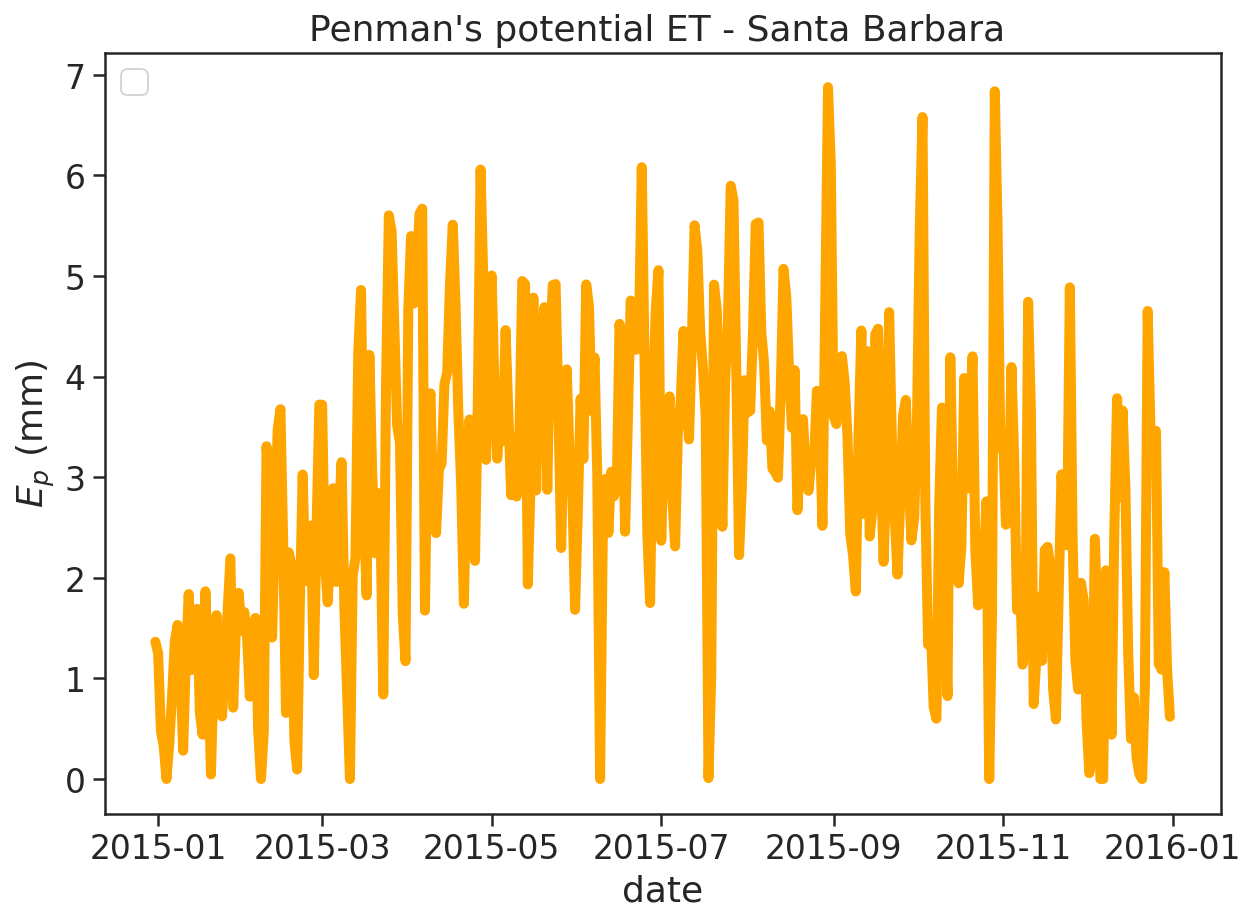

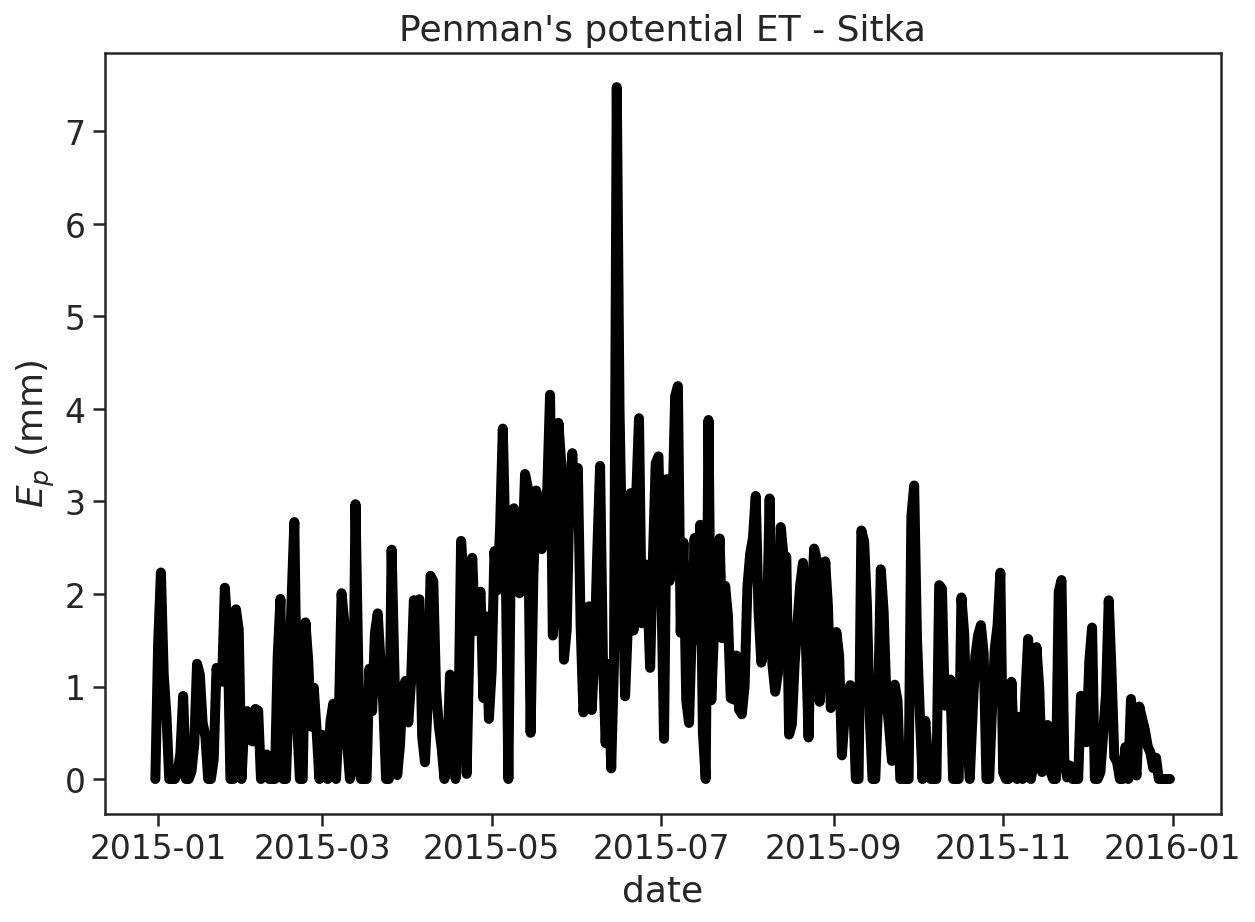

In [24]:
#graph Santa Barbara:
fig, ax = plt.subplots(1, figsize=(10,7))
ax.plot(df_pen_cal['E_penman'], color="orange",  linewidth=5)
ax.set(xlabel="date",
       ylabel=r"$E_p$ (mm)",
       title="Penman's potential ET - Santa Barbara ");
ax.legend(loc='upper left')
#graph Sitka:
fig, ax = plt.subplots(1, figsize=(10,7))
ax.plot(df_pen_ak['E_penman'], color="black",linewidth=5)
ax.set(xlabel="date",
       ylabel=r"$E_p$ (mm)",
       title="Penman's potential ET - Sitka");



We will summarize the findings in the table (You can double-click to see the calculations)

<!--
```python
#Some additional calculations are made in order to include them in the analysis:
print(df_pen_cal['E_penman'].sum() )
print(df_pen_ak['E_penman'].sum()  )
print(df_pen_cal['E_penman'].mean()*30  )
print("cal min = ",df_pen_cal['E_penman'].mean()*30  )
print("ak max = ",penman_smooth.max()*30  )
print("cal max = ",penman_smooth_cal.max()*30  )
print("ak average = ",df_ak_ak['Ep'].mean()*30  )
print("cal average = ",df_pen_cal['Ep'].mean()*30  )

```
-->

| Station | Sitka (Alaska) | Santa Barbara (California) |
| --- | --- | --- |
|Total ET | 437 (mm)|  1047 (mm) |
| Average ET |35.8 (mm)|  85.8 (mm) |
| ET minimum (monthly average) | 18.2 (mm) | 29.43 (mm) |
| ET maximum (monthly average)  | 77.9 (mm) |121.7 (mm) |

It can be seen from the table that the trend obtained using the Thornthwaite estimation is the same as the trend we obtained using the Penman equation:
Even according to Panman the ET in Santa Barbara is higher in every parameter.

There are 2 main differences between the methods:
1. The months in which the highest amount of ET was different. While according to Thornthwaite estimation we have seen that there are differences between Santa Barbara (October) and Sitka (August), if you look at the graphs obtained using the Penman equation you can see that in Santa Barbara the situation does look similar but in Sitka the higher amount of ET is actually in July-June. This difference may be due to the inaccuracy that exists in the Thornthwaite estimation.
2.  The amount of ET calculated using Penman was higher in Santa Barbara but lower in Sitka. Now consider these differences in quantities and percentages:

In [25]:
#For Santa Barbara:
total_ET_pen_cal = df_pen_cal['E_penman'].sum()           #the amount of ET tatal calculated by Penman in Santa Barbara
total_ET_th_cal = df_th_cal['Ep'].sum()                   #the amount of ET tatal calculated by Tornthwaite in Santa Barbara
delta_cal = total_ET_pen_cal - total_ET_th_cal            #the different in mm/year
Percent_deviation_cal = (delta_cal/total_ET_pen_cal)*100  #the deviation between the 2 equtions in %

#For Sitka:
total_ET_pen_ak = df_pen_ak['E_penman'].sum() #the amount of ET tatal calculated by Penman in Sitka
total_ET_th_ak = df_th_ak['Ep'].sum()         #the amount of ET tatal calculated by Tornthwaite in Sitka
delta_ak =total_ET_th_ak - total_ET_pen_ak    # the different in mm/year
Percent_deviation_ak = (delta_ak/total_ET_pen_ak)*100  #the deviation between the 2 equtions in %


#printing the results:
print ("The difference between the ET in Santa Barbara calculated using the Penman equation and the quantity calculated using the Thornthwaite estimation is",delta_cal, "[mm] more by Penman. The deviation is",Percent_deviation_cal, "%")

print("The difference between the ET in Sitka calculated using the Penman equation and the quantity calculated using the Thornthwaite estimation is",delta_ak, "[mm] more by Thornthweite. The deviation is",Percent_deviation_ak, "%")

The difference between the ET in Santa Barbara calculated using the Penman equation and the quantity calculated using the Thornthwaite estimation is 305.7170741298536 [mm] more by Penman. The deviation is 29.190333559329357 %
The difference between the ET in Sitka calculated using the Penman equation and the quantity calculated using the Thornthwaite estimation is 90.57707671186137 [mm] more by Thornthweite. The deviation is 20.7125342155102 %


now lets create a final graph to see the differences between the methods everywhere. Since the Penman equation was calculated for each day we will also create in the graph a “running average” in order to see the differences in good shape:

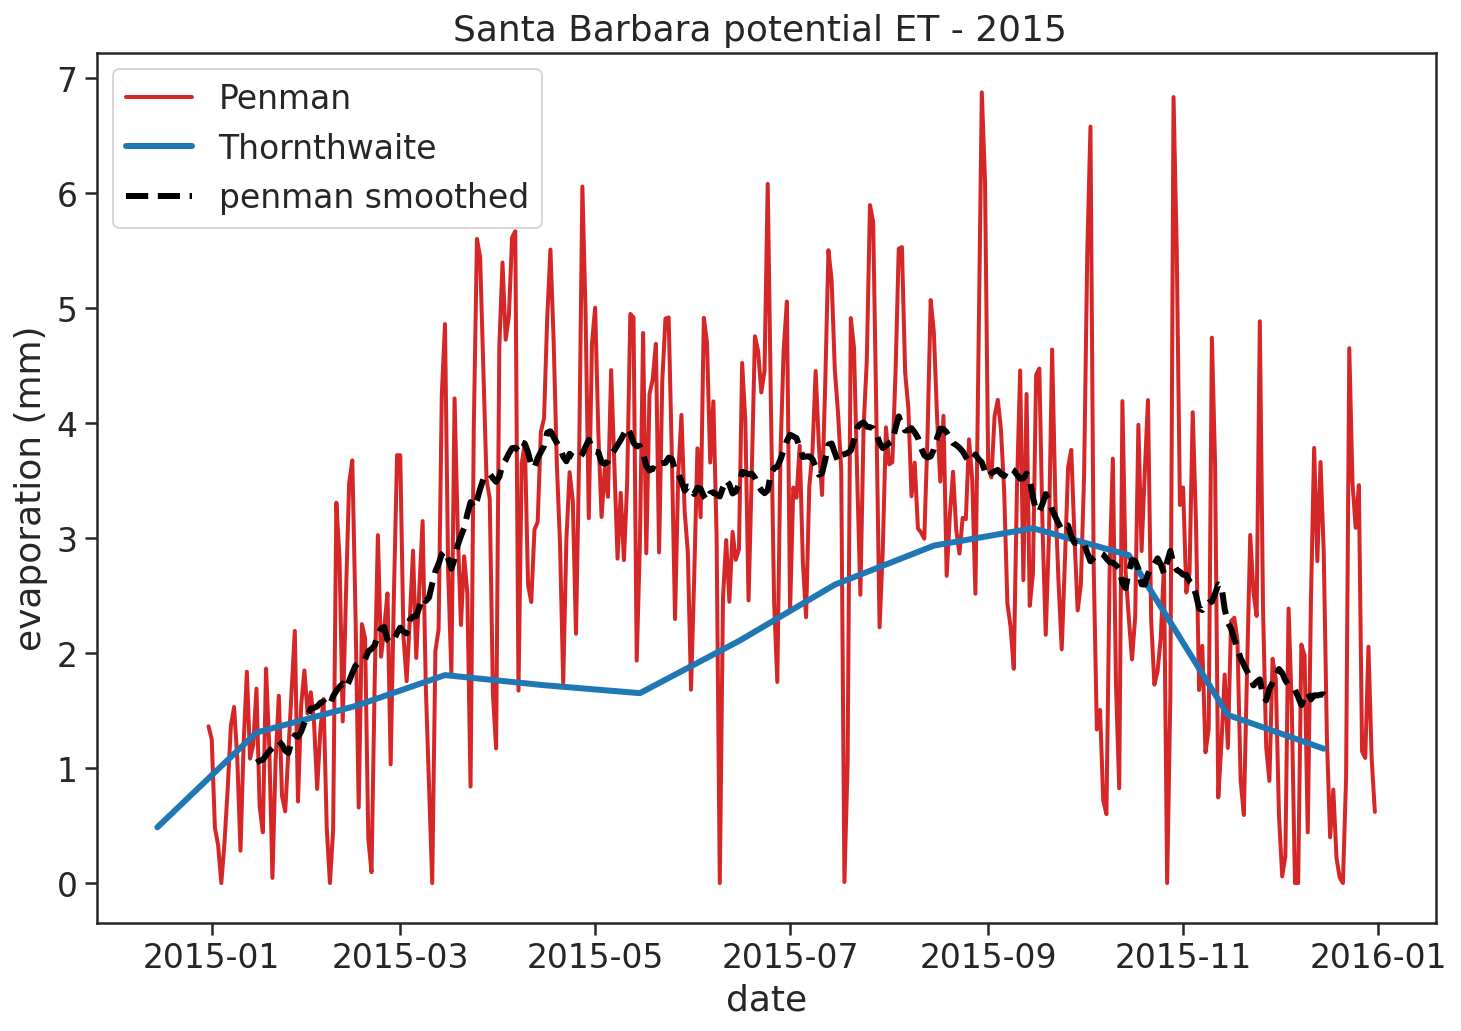

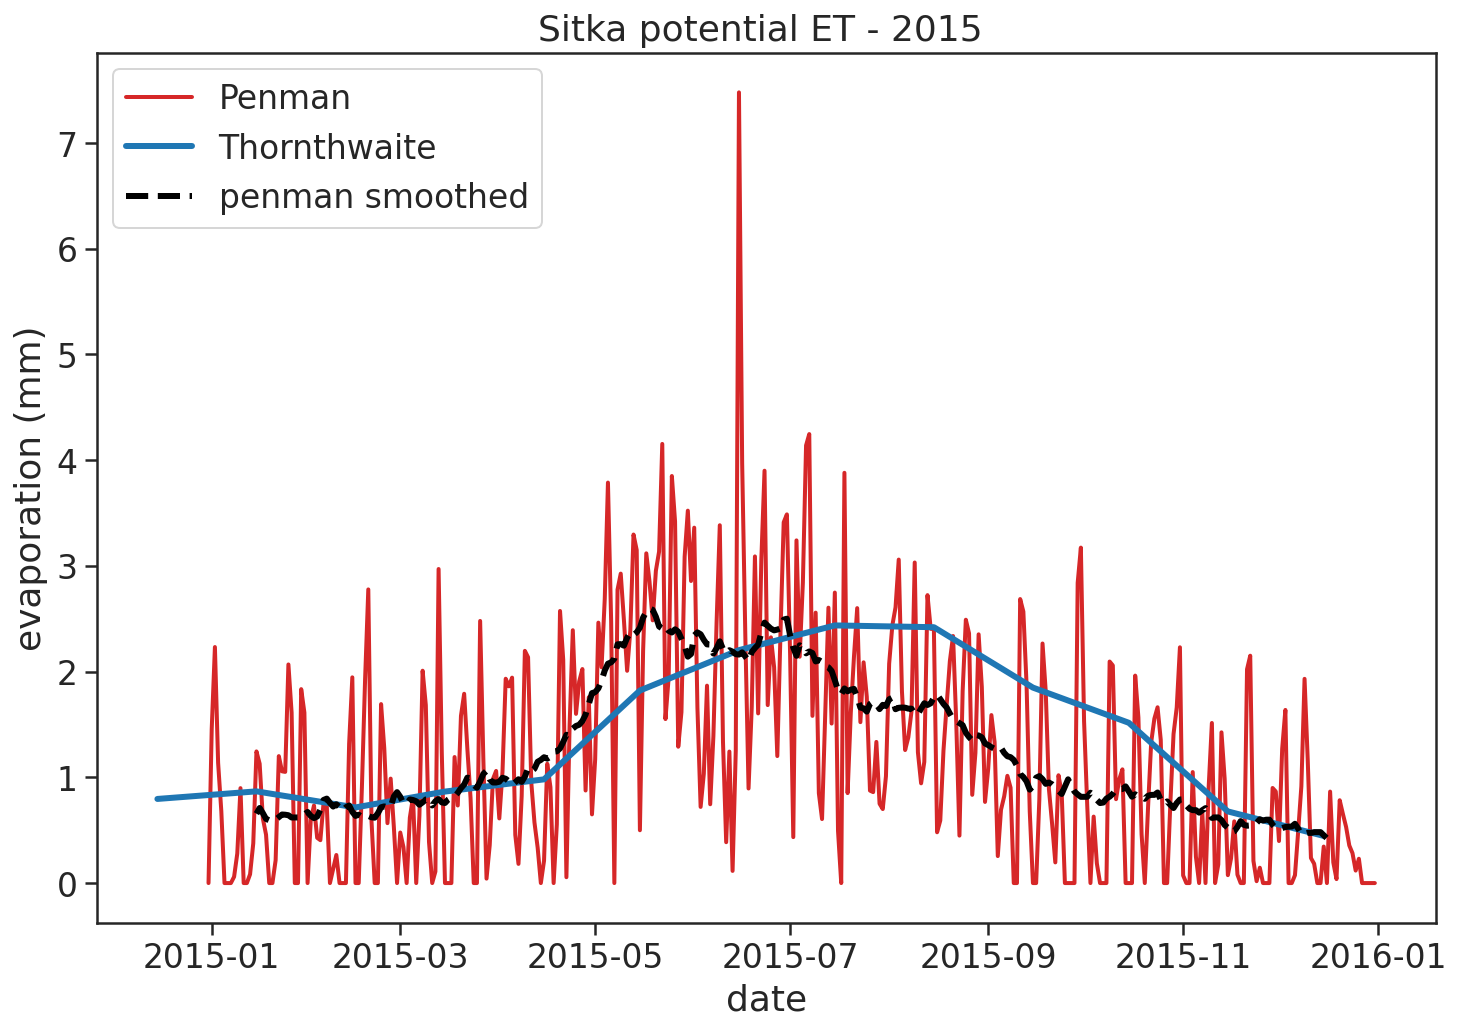

In [26]:
#graph for Santa Barbara
fig, ax = plt.subplots(1, 1, figsize=(12,8))
ax.plot(df_pen_cal['E_penman'], color="tab:red", label="Penman", linewidth=2)
ax.plot(df_th_cal['Ep']/30, color="tab:blue", label="Thornthwaite", linewidth=3) #we have to normalize the results of df_th
penman_smooth_cal = df_pen_cal['E_penman'].rolling(30, center=True).mean()           #smooth avarege
plt.plot(penman_smooth_cal, label='penman smoothed', color="black", linestyle="--", linewidth=3)
ax.set(xlabel="date",
       ylabel="evaporation (mm)",
       title="Santa Barbara potential ET - 2015 ")
ax.legend(loc='upper left')

#graph for Sitka
fig, ax = plt.subplots(1, 1, figsize=(12,8))
ax.plot(df_pen_ak['E_penman'], color="tab:red", label="Penman", linewidth=2)
ax.plot(df_th_ak['Ep']/30, color="tab:blue", label="Thornthwaite", linewidth=3) #we have to normalize the results of df_th
penman_smooth = df_pen_ak['E_penman'].rolling(30, center=True).mean()          #smooth avarege
plt.plot(penman_smooth, label='penman smoothed', color="black", linestyle="--", linewidth=3)
ax.set(xlabel="date",
       ylabel="evaporation (mm)",
       title="Sitka potential ET - 2015 ")
ax.legend(loc = 'upper left')


### 3) Conclusions:
In general, the impression from the two graphs is relatively the same:
**Thornthwaite estimation gives us in general the same trend we see also from the Penman equation**. The main significance of this conclusion depends on our desire to accurately predict ET. In case we want to get a general assessment of the trend of ET it is definitely possible to use Thornthwaite estimation. When we want to observe a sharper resolution and identify subtle differences we will need to use the Penman equation. For example when we want to plan seasonal irrigation in a particular area, one can definitely rely on Thornthwaite estimation. But if it is important for us to know for specific time periods like day or week this would already be a less accurate estimate.

In addition it should be remembered that Thornthwaite estimation requires us to know only the temp and this is a very big advantage for places where we lack data. In such cases one can certainly consider Thornthwaite estimation.

It is important to remember that Thornthwaite estimation is an empirical equation for [certain regions](https://yairmau.com/jupyter/2020/02/01/evapotranspiration-exercises.html#Part-1:-Thornthwaite-estimation). It is important to adjust the variables to the area we are examining if there is such a possibility
